<a href="https://colab.research.google.com/github/swilsonmfc/stable-diffusion/blob/main/FGVCAircraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP & FGVC-Aircraft

# Install

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-47keh2_0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-47keh2_0
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


# Setup

In [2]:
!nvidia-smi

Thu May 25 10:52:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from pkg_resources import packaging

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, BatchSampler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import clip

import skimage
import IPython.display
from PIL import Image

# Data

In [110]:
!wget -O data.tar.gz https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz

--2023-05-25 10:44:56--  https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2753340328 (2.6G) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   2.56G  14.1MB/s    in 4m 4s   

2023-05-25 10:49:02 (10.8 MB/s) - ‘data.tar.gz’ saved [2753340328/2753340328]



In [ ]:
!gunzip data.tar.gz
!tar -xvf data.tar

In [5]:
train_df = pd.read_fwf('fgvc-aircraft-2013b/data/images_family_train.txt', 
                 colspecs=[(0, 7), (7, 100)], 
                 header=None,
                 dtype={'image':str},
                 names=['image', 'category'])
train_df

,image,category
0,1025794,Boeing 707
1,1340192,Boeing 707
2,0056978,Boeing 707
3,0698580,Boeing 707
4,0450014,Boeing 707
...,...,...
3329,1577680,Yak-42
3330,1826676,Yak-42
3331,0472681,Yak-42
3332,1597829,Yak-42


In [6]:
val_df = pd.read_fwf('fgvc-aircraft-2013b/data/images_family_val.txt', 
                 colspecs=[(0, 7), (7, 100)], 
                 header=None,
                 dtype={'image':str},
                 names=['image', 'category'])
val_df

,image,category
0,0481847,Boeing 707
1,0810608,Boeing 707
2,1514481,Boeing 707
3,0887066,Boeing 707
4,1318819,Boeing 707
...,...,...
3328,1203670,Yak-42
3329,0944182,Yak-42
3330,1340345,Yak-42
3331,0765754,Yak-42


In [7]:
print(len(train_df), len(val_df))
print(len(train_df.category.unique()), len(val_df.category.unique()))
train_df.category.unique()

3334 3333
70 70


array(['Boeing 707', 'Boeing 727', 'Boeing 737', 'Boeing 747',
       'Boeing 757', 'Boeing 767', 'Boeing 777', 'A300', 'A310', 'A320',
       'A330', 'A340', 'A380', 'ATR-42', 'ATR-72', 'An-12', 'BAE 146',
       'BAE-125', 'Beechcraft 1900', 'Boeing 717', 'C-130', 'C-47',
       'CRJ-200', 'CRJ-700', 'Cessna 172', 'Cessna 208',
       'Cessna Citation', 'Challenger 600', 'DC-10', 'DC-3', 'DC-6',
       'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6', 'Dash 8', 'DR-400',
       'Dornier 328', 'Embraer E-Jet', 'EMB-120', 'Embraer ERJ 145',
       'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16', 'F/A-18',
       'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50',
       'Fokker 70', 'Global Express', 'Gulfstream', 'Hawk T1', 'Il-76',
       'L-1011', 'MD-11', 'MD-80', 'MD-90', 'Metroliner', 'King Air',
       'PA-28', 'SR-20', 'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado',
       'Tu-134', 'Tu-154', 'Yak-42'], dtype=object)

# CLIP Model

In [8]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [9]:
model, preprocess = clip.load('ViT-B/32')
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

# Pre-Processor

## Image

In [10]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f5ddce313f0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text

In [11]:
clip.tokenize('Aircraft Classification')

tensor([[49406,  7706, 26612, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Evaluation

### Accuracy

In [12]:
def accuracy(val_df):
  results = pd.DataFrame(columns=['category', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5'])

  # Prep Categories
  classifications = []
  category_to_index = {}
  index_to_category = {}

  # Tokens to Index
  for cat in list(val_df.category.unique()):
    classifications.append(cat)
    category_to_index[cat] = len(classifications) - 1
    index_to_category[len(classifications) - 1] = cat

  # Generate Prompts & Text Features
  prompts = [f'This is a photo of a {label} aircraft' for label in classifications]
  prompt_tokens = clip.tokenize(prompts).cuda()
  with torch.no_grad():
      text_features = model.encode_text(prompt_tokens).float()
      text_features /= text_features.norm(dim=-1, keepdim=True)

  for index, row in val_df.iterrows():
    # Image Features
    filename = f"fgvc-aircraft-2013b/data/images/{row['image']}.jpg"
    image = Image.open(filename).convert("RGB")
    image_input = torch.tensor(np.stack([preprocess(image)])).cuda()
    with torch.no_grad():
      image_features = model.encode_image(image_input).float()
      image_features /= image_features.norm(dim=-1, keepdim=True)
    
    # Softmax on Cosine Similarity
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

    # Build results
    category = row['category']
    top = [index_to_category[label] for label in top_labels[0].numpy()]
    results.loc[index] = [category] + top
  
  # Prepare
  results['top1'] = results.category == results.pred_1
  results['top5'] = results.drop(columns=['category']).isin(results.category).any(1)
  results

  grp = results.groupby('category').agg({'category': 'count', 
                                 'top1': 'sum', 
                                 'top5': 'sum'})
  grp['top1_acc'] = grp.top1 * 100. / grp.category
  grp['top5_acc'] = grp.top5 * 100. / grp.category
  return grp

In [13]:
accuracy_df = accuracy(val_df)

<ipython-input-12-df1d8c0991a7>:42: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  results['top5'] = results.drop(columns=['category']).isin(results.category).any(1)


## Examples

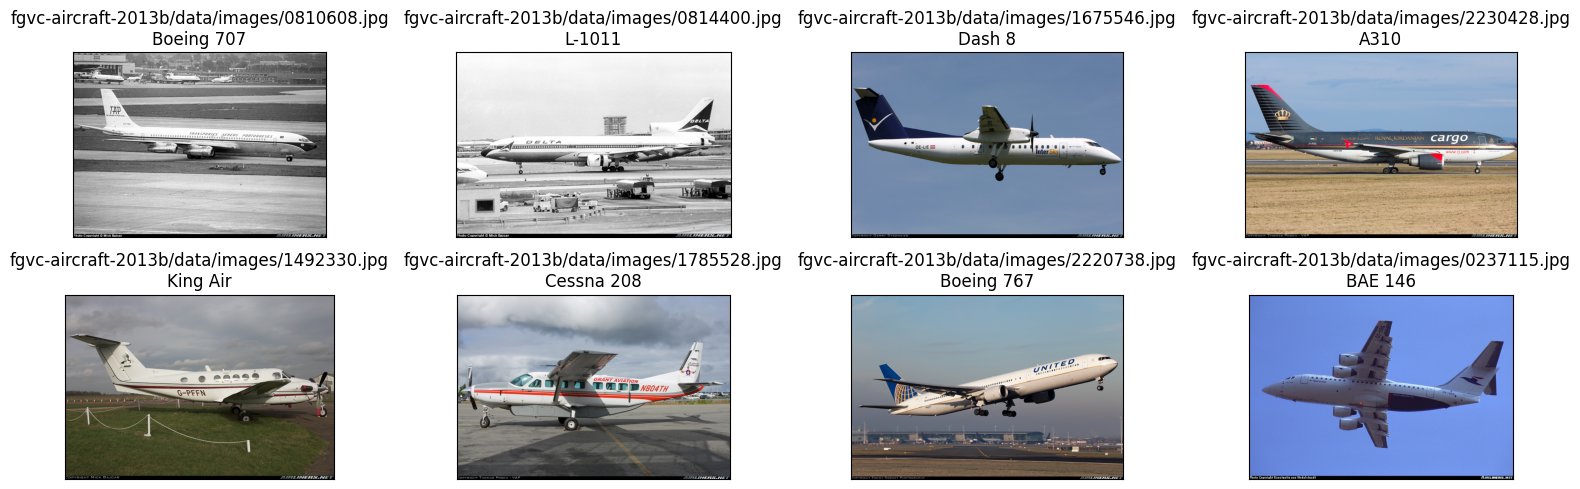

In [14]:
original_images = []
images = []
texts  = []
plt.figure(figsize=(16, 5))

sample_df = val_df.sample(n=8, random_state=1337)
for _, row in sample_df.iterrows():
  filename = f"fgvc-aircraft-2013b/data/images/{row['image']}.jpg"
  category = row['category']
  image = Image.open(filename).convert("RGB")
  
  plt.subplot(2, 4, len(images) + 1)
  plt.imshow(image)
  plt.title(f"{filename}\n{category}")
  plt.xticks([])
  plt.yticks([])

  original_images.append(image)
  images.append(preprocess(image))
  texts.append(category)
plt.tight_layout()

## Features

In [15]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(['This is photo of a ' + desc for desc in texts]).cuda()

In [16]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features  = model.encode_text(text_tokens).float()

## Cosine Similarity

In [17]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

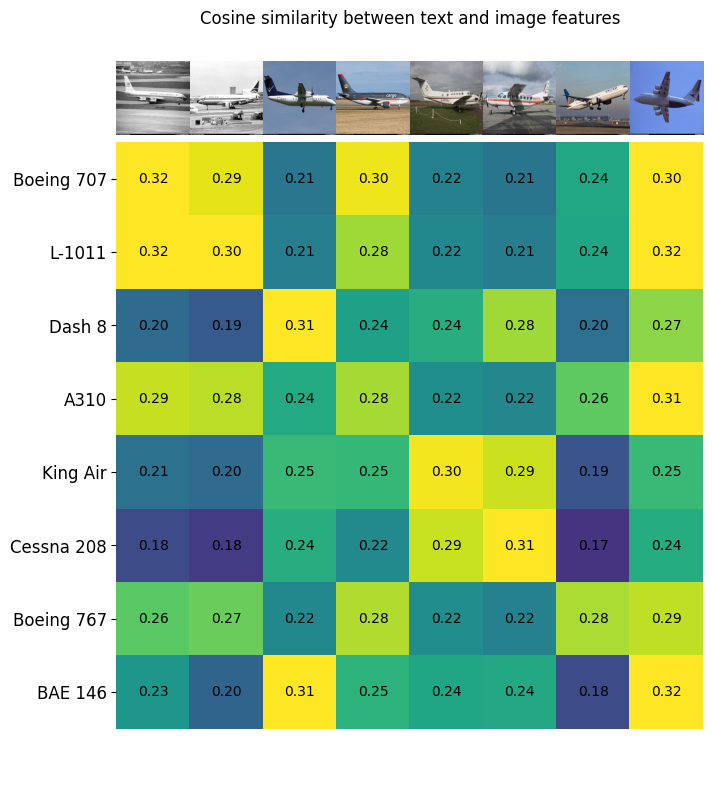

In [18]:
count = len(sample_df.category)

plt.figure(figsize=(12, 10))
plt.imshow(similarity, vmin=0.15, vmax=0.3)
plt.yticks(range(count), texts, fontsize=12)
plt.xticks([])

for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f'{similarity[y, x]:.2f}', ha='center', va='center')

for side in ['left', 'top', 'right', 'bottom']:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title('Cosine similarity between text and image features');

## Zero Shot

In [19]:
classifications = list(val_df.category.unique())
prompts = [f'This is a photo of a {label} aircraft' for label in classifications]
prompt_tokens = clip.tokenize(prompts).cuda()

In [20]:
with torch.no_grad():
    text_features = model.encode_text(prompt_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

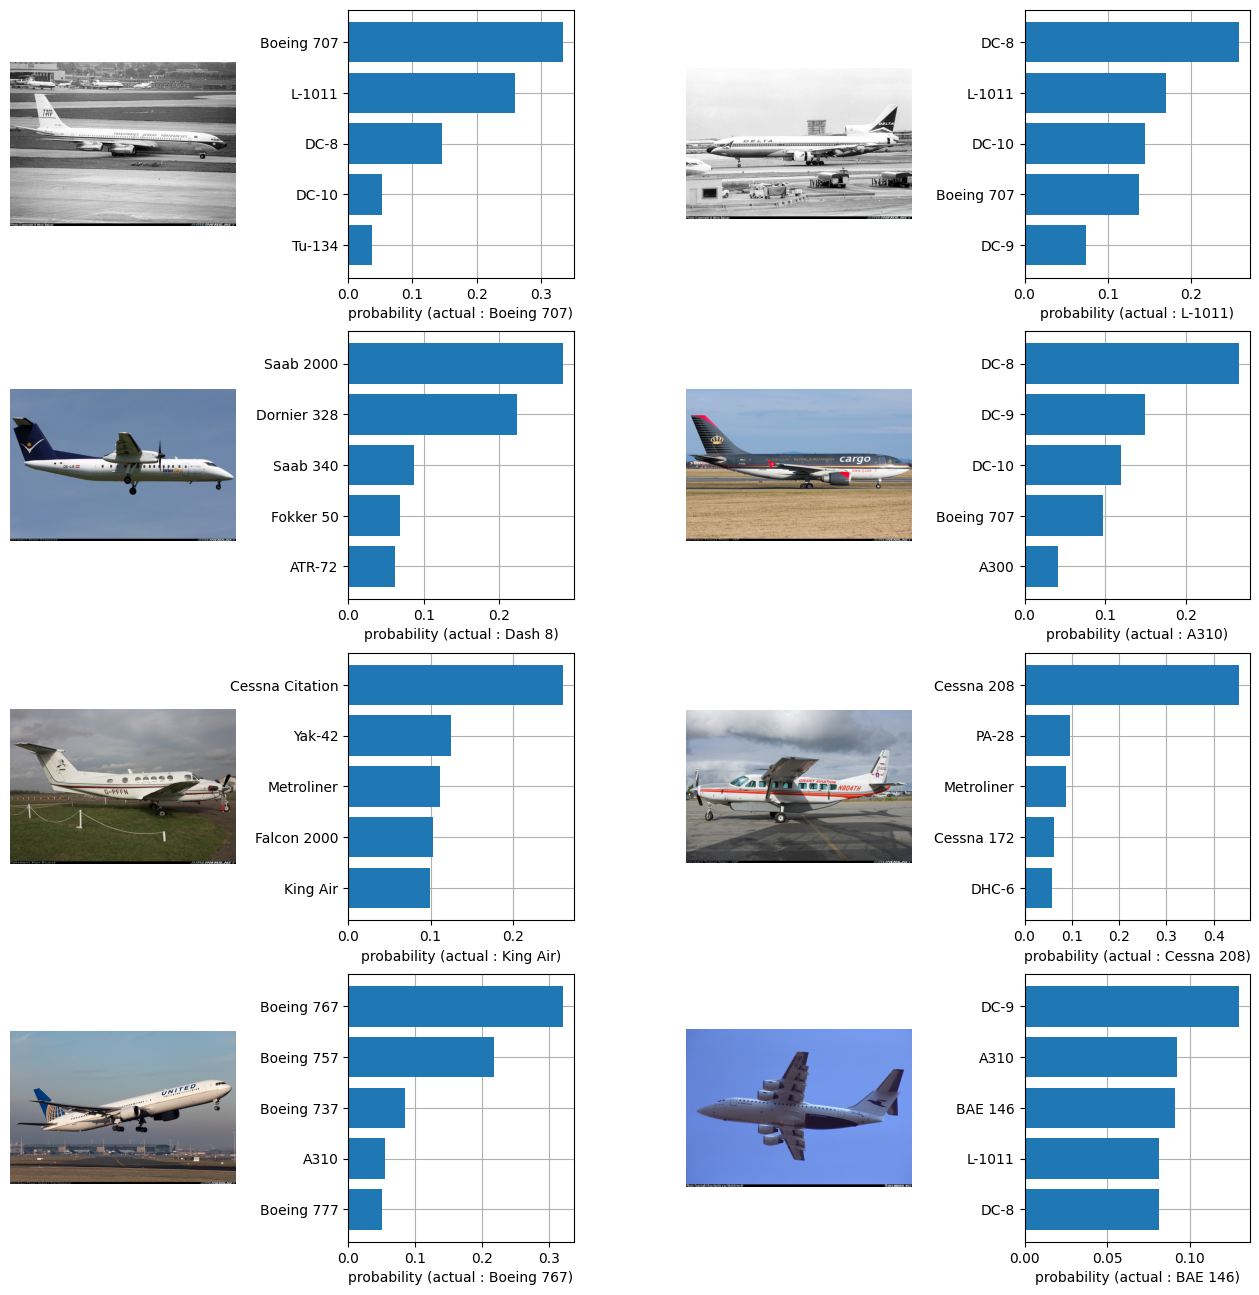

In [21]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classifications[index] for index in top_labels[i].numpy()])
    plt.xlabel(f'probability (actual : {texts[i]})')

plt.subplots_adjust(wspace=0.5)
plt.show()

# Fine Tuning
* Dataset
* Training
* Evaluation

## Parameters

In [22]:
LEARNING_RATE = 1e-5
BATCH_SIZE = 64
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset

In [23]:
class AirlineDataset(Dataset):
  def __init__(self, df, preprocess):
    self.preprocess = preprocess
    self.img_paths  = []
    self.categories = []
    self.category_set = {}
    
    for _, row in df.iterrows():
      img_path, category = row['image'], row['category']
      filename = f'fgvc-aircraft-2013b/data/images/{img_path}.jpg'
      self.img_paths.append(filename)
      self.categories.append(category)
      if category not in self.category_set:
        self.category_set[category] = len(self.category_set)
    
    self.processed_cache = {}
    for img_path in self.img_paths:
      self.processed_cache[img_path] = self.preprocess(Image.open(img_path).convert('RGB'))
    self.path2label = {path: self.category_set[cat] for path, cat in zip(self.img_paths, self.categories)}
      
  def __len__(self):
    return len(self.categories)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    image = self.processed_cache[img_path]
    category = self.categories[idx]
    label = self.path2label[img_path]
    return image, category, label

In [24]:
train_dataset = AirlineDataset(train_df, preprocess)
test_dataset = AirlineDataset(val_df, preprocess)
len(train_dataset), len(test_dataset), train_dataset[0]

(3334,
 3333,
 (tensor([[[ 1.4340,  1.4340,  1.4340,  ...,  1.4048,  1.4048,  1.4048],
           [ 1.4340,  1.4340,  1.4340,  ...,  1.4194,  1.4048,  1.4048],
           [ 1.4340,  1.4340,  1.4486,  ...,  1.4048,  1.4048,  1.4048],
           ...,
           [-1.7923, -0.8580, -0.9310,  ..., -0.6682, -0.1572, -0.6098],
           [-1.2813, -0.8434, -0.8872,  ..., -0.3908, -0.6974, -1.2813],
           [-1.3105, -1.3689, -1.6025,  ..., -0.8434, -1.3981, -1.3981]],
  
          [[ 1.5646,  1.5646,  1.5646,  ...,  1.5346,  1.5346,  1.5346],
           [ 1.5646,  1.5646,  1.5646,  ...,  1.5496,  1.5346,  1.5346],
           [ 1.5646,  1.5646,  1.5796,  ...,  1.5346,  1.5346,  1.5346],
           ...,
           [-1.7521, -0.7316, -0.8216,  ..., -0.4464,  0.1989, -0.3864],
           [-1.1818, -0.6865, -0.7466,  ..., -0.0712, -0.3864, -1.1818],
           [-1.1668, -1.2418, -1.5270,  ..., -0.5815, -1.2568, -1.3469]],
  
          [[ 1.6624,  1.6624,  1.6624,  ...,  1.6340,  1.6340,  1.6340

In [25]:
class BalancedBatchSampler(BatchSampler):
  def __init__(self, labels, n_classes, n_samples):
    self.labels = labels
    self.labels_set = list(set(self.labels.numpy()))
    self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                              for label in self.labels_set}
    for l in self.labels_set:
        np.random.shuffle(self.label_to_indices[l])
    self.used_label_indices_count = {label: 0 for label in self.labels_set}
    self.count = 0
    self.n_classes = n_classes
    self.n_samples = n_samples
    self.n_dataset = len(self.labels)
    self.batch_size = self.n_samples * self.n_classes

  def __iter__(self):
    self.count = 0
    while self.count + self.batch_size < self.n_dataset:
      classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
      indices = []
      for class_ in classes:
        indices.extend(self.label_to_indices[class_][
                       self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                    class_] + self.n_samples])
        self.used_label_indices_count[class_] += self.n_samples
        if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
          np.random.shuffle(self.label_to_indices[class_])
          self.used_label_indices_count[class_] = 0
      yield indices
      self.count += self.n_classes * self.n_samples

  def __len__(self):
    return self.n_dataset // self.batch_size
    
train_labels = torch.tensor([item[2] for item in train_dataset])
train_sampler = BalancedBatchSampler(train_labels, BATCH_SIZE, 1)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler)

test_labels = torch.tensor([item[2] for item in test_dataset])
test_sampler = BalancedBatchSampler(test_labels, BATCH_SIZE, 1)
test_dataloader = DataLoader(test_dataset, batch_sampler=test_sampler)

#train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)
#len(train_dataset), len(test_dataset), train_dataset[0]

## Training

In [26]:
def convert_models_to_fp32(model): 
  for p in model.parameters(): 
    p.data = p.data.float() 
    p.grad.data = p.grad.data.float() 

if DEVICE == 'cpu':
  model.float()

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dataloader) * EPOCHS)

In [27]:
best_te_loss = 1e5
best_ep = -1
for epoch in range(EPOCHS):
  print(f'running epoch {epoch}, best test loss {best_te_loss} after epoch {best_ep}')
  step = 0
  tr_loss = 0
  model.train()
  pbar = tqdm(train_dataloader, leave=False)
  for batch in pbar:
    if len(batch[0]) < BATCH_SIZE:
      continue
    
    step += 1
    optimizer.zero_grad()

    images, texts, _ = batch
    images = images.to(DEVICE)
    texts = clip.tokenize(texts).to(DEVICE)

    logits_per_image, logits_per_text = model(images, texts)
    ground_truth = torch.arange(BATCH_SIZE).to(DEVICE)

    total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth)) / 2
    total_loss.backward()
    tr_loss += total_loss.item()
    
    if DEVICE == 'cpu':
      optimizer.step()
      scheduler.step()
    else:
      convert_models_to_fp32(model)
      optimizer.step()
      scheduler.step()
      clip.model.convert_weights(model)
    
    pbar.set_description(f'train batchCE: {total_loss.item()}', refresh=True)
  tr_loss /= step
    
  step = 0
  te_loss = 0
  with torch.no_grad():
    model.eval()
    test_pbar = tqdm(test_dataloader, leave=False)
    for batch in test_pbar:
      if len(batch[0]) < BATCH_SIZE:
        continue

      step += 1
      images, texts, _ = batch
      images = images.to(DEVICE)
      texts = clip.tokenize(texts).to(DEVICE)
      logits_per_image, logits_per_text = model(images, texts)
      ground_truth = torch.arange(BATCH_SIZE).to(DEVICE)

      total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
      te_loss += total_loss.item()
      test_pbar.set_description(f'test batchCE: {total_loss.item()}', refresh=True)
    te_loss /= step
      
  if te_loss < best_te_loss:
    best_te_loss = te_loss
    best_ep = epoch
    torch.save(model.state_dict(), 'best_model.pt')
  print(f'epoch {epoch}, tr_loss {tr_loss}, te_loss {te_loss}')
torch.save(model.state_dict(), 'last_model.pt')

running epoch 0, best test loss 100000.0 after epoch -1


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

epoch 0, tr_loss 1.5783973106971154, te_loss 1.3228665865384615
running epoch 1, best test loss 1.3228665865384615 after epoch 0


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

epoch 1, tr_loss 0.5890878530649039, te_loss 1.3075045072115385
running epoch 2, best test loss 1.3075045072115385 after epoch 1


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

epoch 2, tr_loss 0.20545607346754807, te_loss 1.248291015625
running epoch 3, best test loss 1.248291015625 after epoch 2


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

epoch 3, tr_loss 0.09299821120042068, te_loss 1.2910344050480769
running epoch 4, best test loss 1.248291015625 after epoch 2


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

epoch 4, tr_loss 0.08179415189302884, te_loss 1.2863018329326923


## Best Model

In [28]:
model, preprocess = clip.load('ViT-B/32')
model.load_state_dict(torch.load('best_model.pt'))

model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

# Evaluation

## Examples

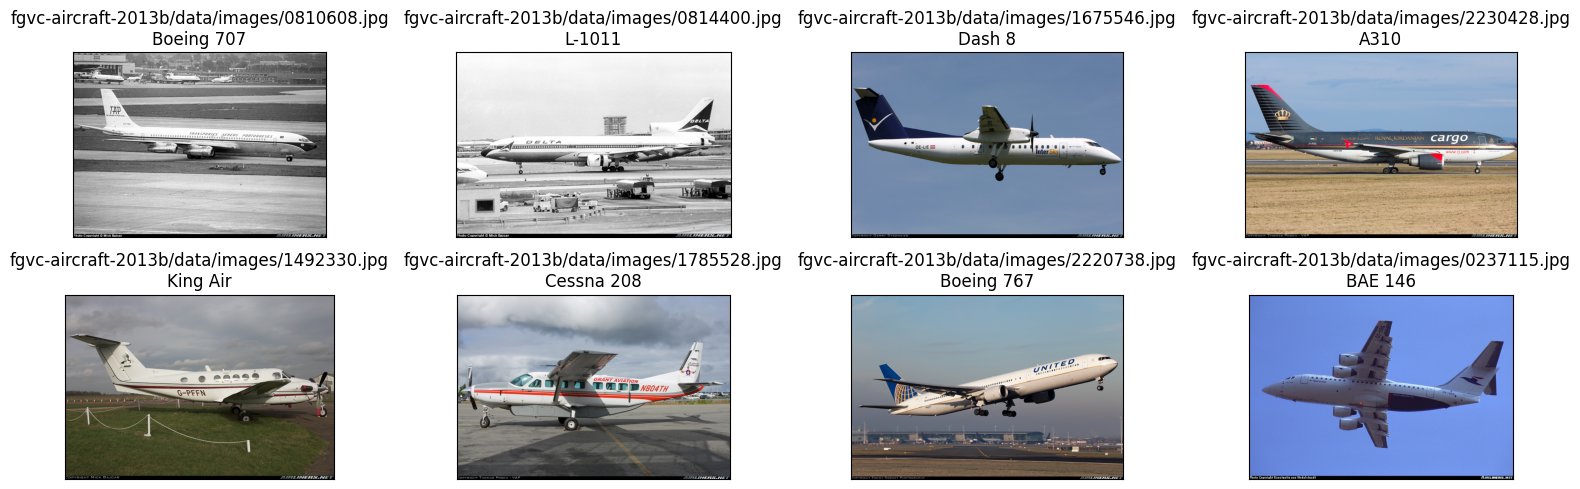

In [29]:
original_images = []
images = []
texts  = []
plt.figure(figsize=(16, 5))

sample_df = val_df.sample(n=8, random_state=1337)
for _, row in sample_df.iterrows():
  filename = f"fgvc-aircraft-2013b/data/images/{row['image']}.jpg"
  category = row['category']
  image = Image.open(filename).convert("RGB")
  
  plt.subplot(2, 4, len(images) + 1)
  plt.imshow(image)
  plt.title(f"{filename}\n{category}")
  plt.xticks([])
  plt.yticks([])

  original_images.append(image)
  images.append(preprocess(image))
  texts.append(category)
plt.tight_layout()

## Features

In [30]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(['This is photo of a ' + desc for desc in texts]).cuda()

In [31]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features  = model.encode_text(text_tokens).float()

## Cosine Similarity

In [32]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

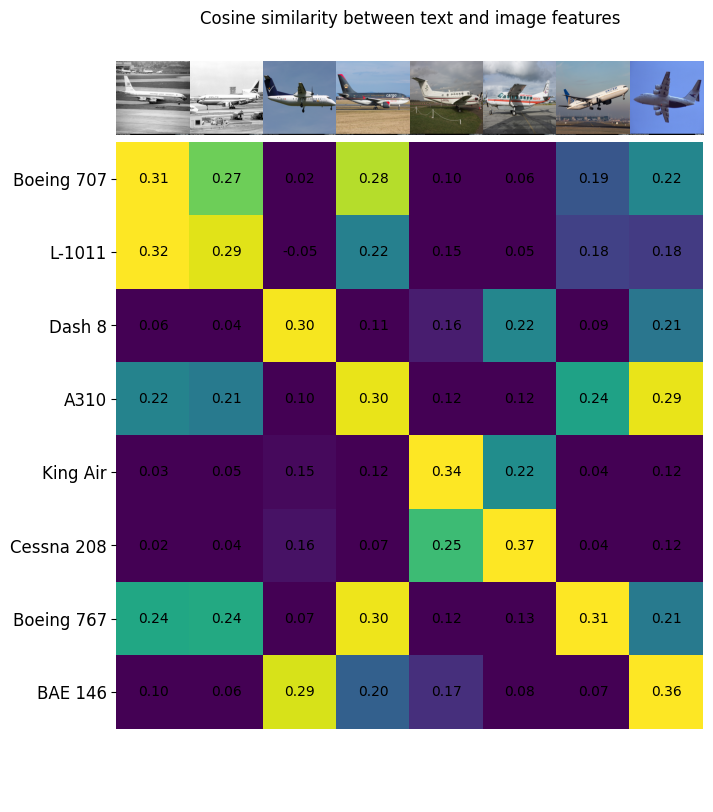

In [33]:
count = len(sample_df.category)

plt.figure(figsize=(12, 10))
plt.imshow(similarity, vmin=0.15, vmax=0.3)
plt.yticks(range(count), texts, fontsize=12)
plt.xticks([])

for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f'{similarity[y, x]:.2f}', ha='center', va='center')

for side in ['left', 'top', 'right', 'bottom']:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title('Cosine similarity between text and image features');

## Zero Shot

In [34]:
classifications = list(val_df.category.unique())
prompts = [f'This is a photo of a {label} aircraft' for label in classifications]
prompt_tokens = clip.tokenize(prompts).cuda()

In [35]:
with torch.no_grad():
    text_features = model.encode_text(prompt_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

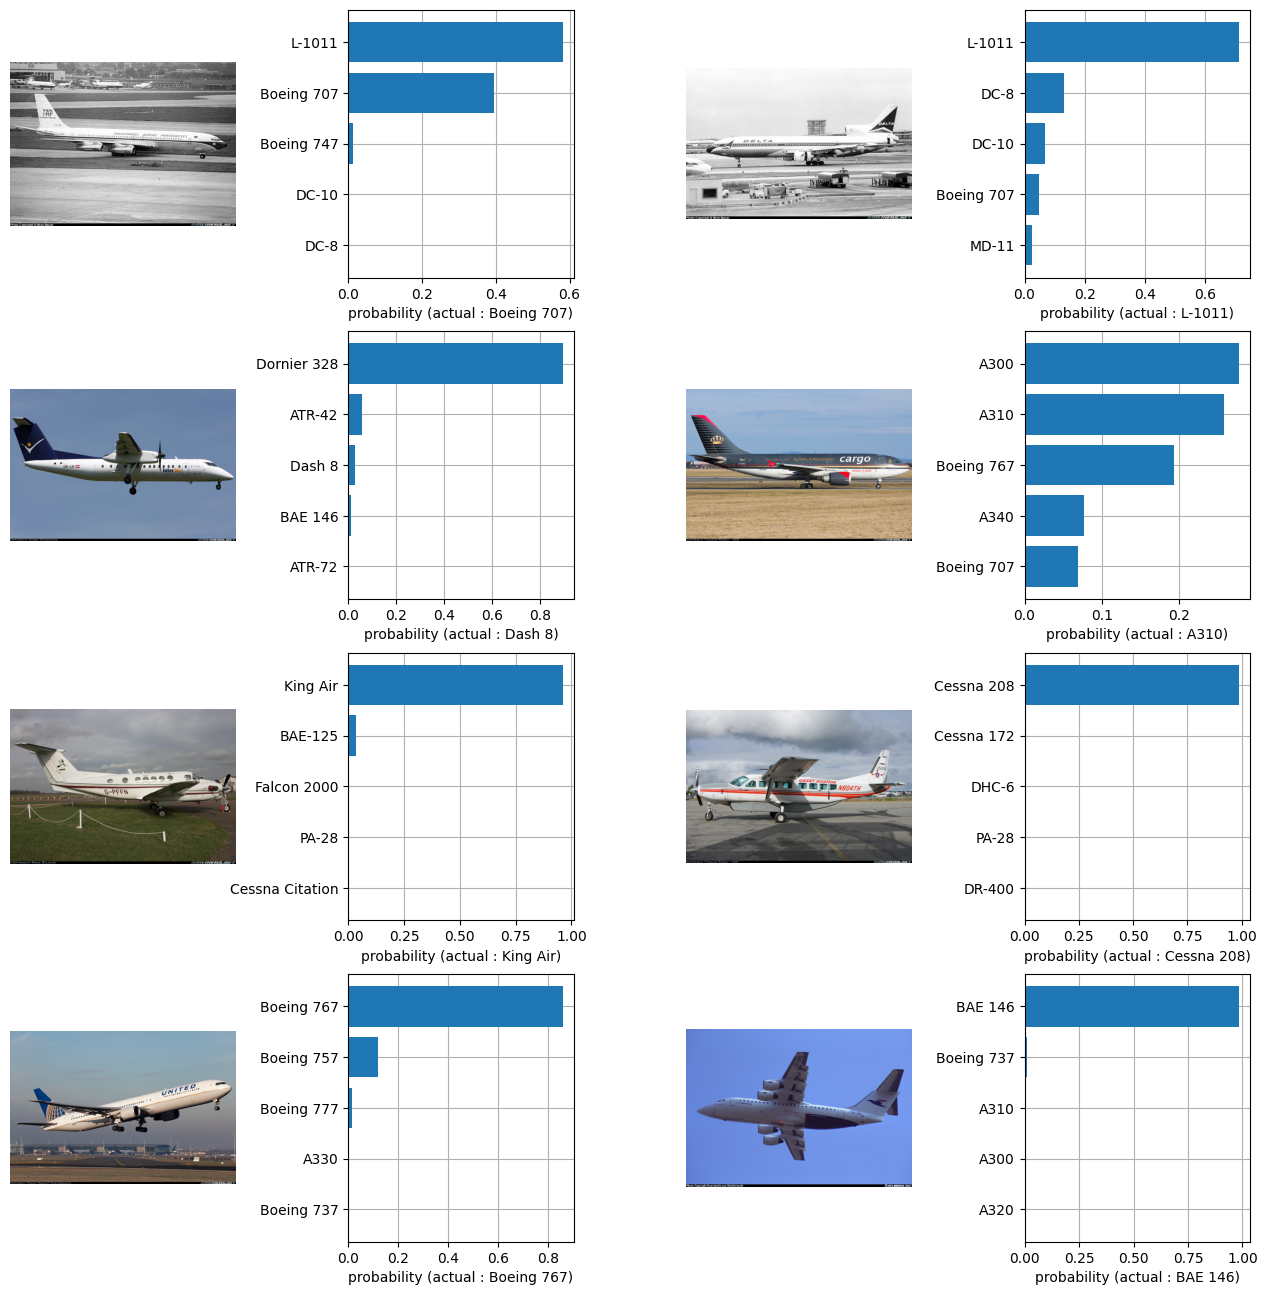

In [36]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classifications[index] for index in top_labels[i].numpy()])
    plt.xlabel(f'probability (actual : {texts[i]})')

plt.subplots_adjust(wspace=0.5)
plt.show()

# Accuracy
* Brute force pass over the validation data for accuracy

### Original CLIP

In [37]:
accuracy_df

,category,top1,top5,top1_acc,top5_acc
category,,,,,
A300,33,1,9,3.030303,27.272727
A310,34,11,28,32.352941,82.352941
A320,133,45,86,33.834586,64.661654
A330,67,31,58,46.268657,86.567164
A340,133,30,105,22.556391,78.947368
...,...,...,...,...,...
Spitfire,33,30,32,90.909091,96.969697
Tornado,33,18,33,54.545455,100.000000
Tu-134,34,1,5,2.941176,14.705882


### Fine Tuned CLIP

In [38]:
accuracy_ft_df = accuracy(val_df)
accuracy_ft_df

<ipython-input-12-df1d8c0991a7>:42: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  results['top5'] = results.drop(columns=['category']).isin(results.category).any(1)


,category,top1,top5,top1_acc,top5_acc
category,,,,,
A300,33,6,21,18.181818,63.636364
A310,34,9,28,26.470588,82.352941
A320,133,33,122,24.812030,91.729323
A330,67,29,52,43.283582,77.611940
A340,133,73,122,54.887218,91.729323
...,...,...,...,...,...
Spitfire,33,31,33,93.939394,100.000000
Tornado,33,32,33,96.969697,100.000000
Tu-134,34,23,32,67.647059,94.117647


### Improvements

In [49]:
pre_ft_df  = accuracy_df.copy()
pre_ft_df = pre_ft_df.rename(columns={'category': 'count'})
pre_ft_df.columns = [f'pre_{col}' for col in pre_ft_df.columns]
pre_ft_df = pre_ft_df.reset_index()

post_ft_df = accuracy_ft_df.copy()
post_ft_df = post_ft_df.rename(columns={'category': 'count'})
post_ft_df.columns = [f'post_{col}' for col in post_ft_df.columns]
post_ft_df = post_ft_df.reset_index()

joined = pd.merge(pre_ft_df, post_ft_df, left_on=['category'], right_on=['category'])
joined['top1_improve'] = joined.post_top1_acc - joined.pre_top1_acc
joined['top5_improve'] = joined.post_top5_acc - joined.pre_top5_acc

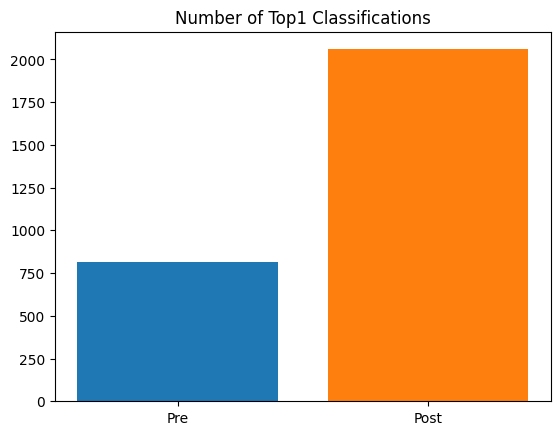

In [55]:
plt.bar('Pre', joined.pre_top1.sum())
plt.bar('Post', joined.post_top1.sum())
plt.title('Number of Top1 Classifications');

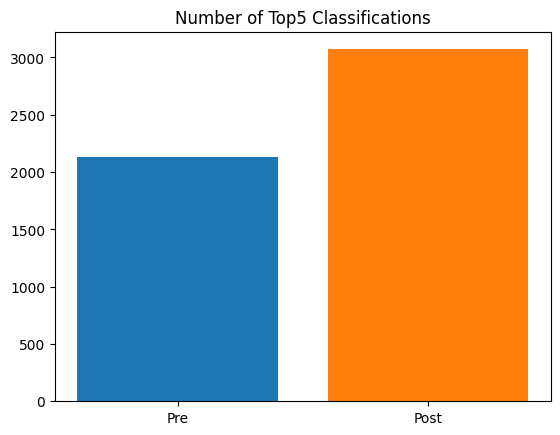

In [56]:
plt.bar('Pre', joined.pre_top5.sum())
plt.bar('Post', joined.post_top5.sum())
plt.title('Number of Top5 Classifications');

In [60]:
joined

,category,pre_count,pre_top1,pre_top5,pre_top1_acc,pre_top5_acc,post_count,post_top1,post_top5,post_top1_acc,post_top5_acc,top1_improve,top5_improve
0,A300,33,1,9,3.030303,27.272727,33,6,21,18.181818,63.636364,15.151515,36.363636
1,A310,34,11,28,32.352941,82.352941,34,9,28,26.470588,82.352941,-5.882353,0.000000
2,A320,133,45,86,33.834586,64.661654,133,33,122,24.812030,91.729323,-9.022556,27.067669
3,A330,67,31,58,46.268657,86.567164,67,29,52,43.283582,77.611940,-2.985075,-8.955224
4,A340,133,30,105,22.556391,78.947368,133,73,122,54.887218,91.729323,32.330827,12.781955
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Spitfire,33,30,32,90.909091,96.969697,33,31,33,93.939394,100.000000,3.030303,3.030303
66,Tornado,33,18,33,54.545455,100.000000,33,32,33,96.969697,100.000000,42.424242,0.000000
67,Tu-134,34,1,5,2.941176,14.705882,34,23,32,67.647059,94.117647,64.705882,79.411765
68,Tu-154,33,1,6,3.030303,18.181818,33,21,32,63.636364,96.969697,60.606061,78.787879


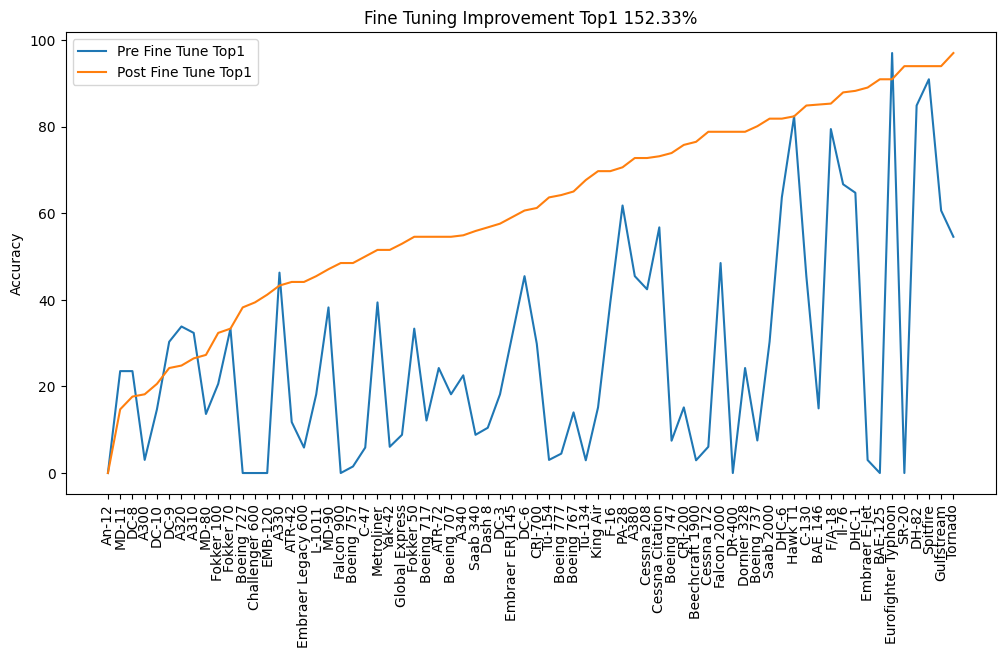

In [85]:
plot_df = joined.copy()
plot_df = plot_df.sort_values('post_top1_acc')
plot_df = plot_df.set_index('category')
plt.figure(figsize=(12, 6))
plt.plot(plot_df.pre_top1_acc, label='Pre Fine Tune Top1')
plt.plot(plot_df.post_top1_acc, label='Post Fine Tune Top1')
plt.legend()
plt.ylabel('Accuracy')
imp = (plot_df.post_top1.sum() - plot_df.pre_top1.sum()) * 100. / plot_df.pre_top1.sum()
plt.title(f'Fine Tuning Improvement Top1 {imp:.2f}%')
plt.xticks(rotation=90);

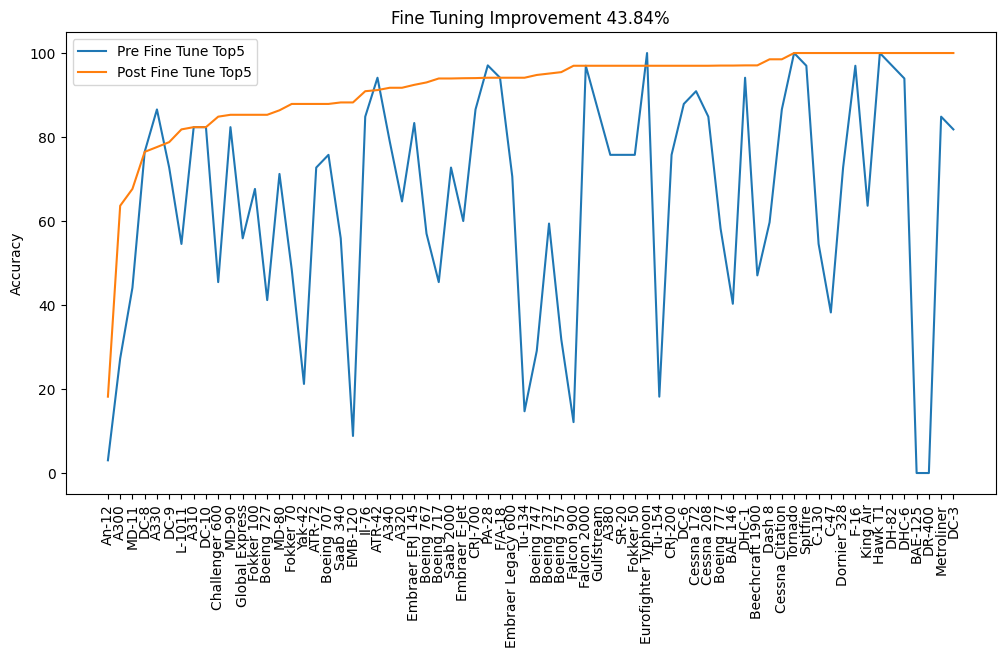

In [84]:
plot_df = joined.copy()
plot_df = plot_df.sort_values('post_top5_acc')
plot_df = plot_df.set_index('category')
plt.figure(figsize=(12, 6))
plt.plot(plot_df.pre_top5_acc, label='Pre Fine Tune Top5')
plt.plot(plot_df.post_top5_acc, label='Post Fine Tune Top5')
plt.legend()
plt.ylabel('Accuracy')
imp = (plot_df.post_top5.sum() - plot_df.pre_top5.sum()) * 100. / plot_df.pre_top5.sum()
plt.title(f'Fine Tuning Improvement Top5 {imp:.2f}%')
plt.xticks(rotation=90);

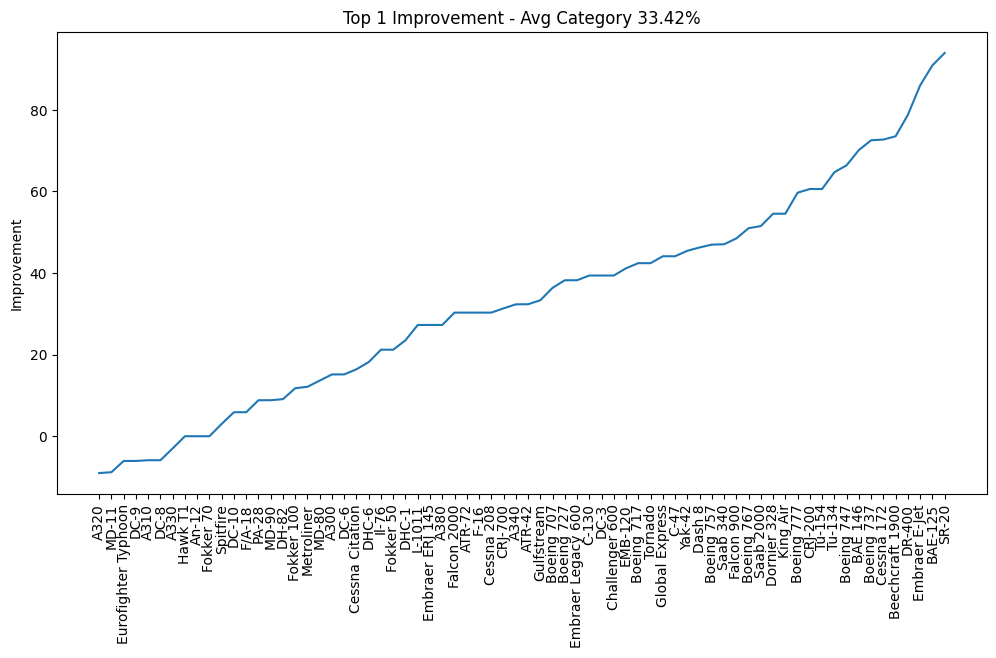

In [87]:
plot_df = joined.copy()
plot_df = plot_df.sort_values('top1_improve')
plot_df = plot_df.set_index('category')
plt.figure(figsize=(12, 6))
plt.plot(plot_df.top1_improve, label='Top1 Improve')
plt.ylabel('Improvement')
plt.title(f'Top 1 Improvement - Avg Category {plot_df.top1_improve.mean():.2f}%')
plt.xticks(rotation=90);

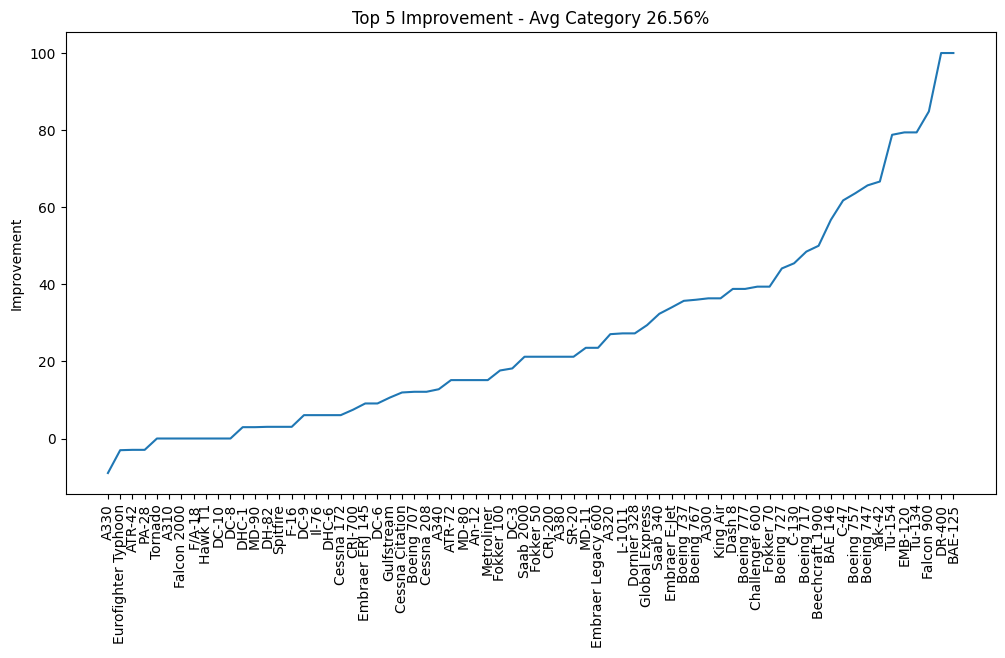

In [88]:
plot_df = joined.copy()
plot_df = plot_df.sort_values('top5_improve')
plot_df = plot_df.set_index('category')
plt.figure(figsize=(12, 6))
plt.plot(plot_df.top5_improve, label='Top5 Improve')
plt.ylabel('Improvement')
plt.title(f'Top 5 Improvement - Avg Category {plot_df.top5_improve.mean():.2f}%')
plt.xticks(rotation=90);